In [2]:
!pip install torchsummary

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
import torchsummary
from tqdm import tqdm

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations 
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

NameError: name 'data' is not defined

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size
    transforms.ToTensor(), # Convert images to PyTorch tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
eurosat = torchvision.datasets.EuroSAT(root="/Home/Documents", download=True, transform=transform)

100%|██████████| 94280567/94280567 [00:04<00:00, 21929294.31it/s]


Extracting /Home/Documents/eurosat/EuroSAT.zip to /Home/Documents/eurosat


In [7]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [8]:
class_names = eurosat.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


In [9]:
train_data = torchvision.datasets.EuroSAT(root="/Home/Documents", download=True, transform=train_transform)
test_data = torchvision.datasets.EuroSAT(root="/Home/Documents", download=True, transform=test_transform)

In [10]:
train_size = 0.8
subset_start = 0
subset_end = int(train_size * len(train_data))
subset_indices = list(range(subset_start, subset_end))
train_set = torch.utils.data.Subset(train_data, subset_indices)
print(len(train_set))
train_set

21600


In [11]:
test_size = 1 - train_size
subset_start = len(train_set)
subset_end = len(train_data)
subset_indices = list(range(subset_start, subset_end))
test_set = torch.utils.data.Subset(test_data, subset_indices)
print(len(test_set))
test_set

5400


In [12]:
num_workers = 2
traind = DataLoader(train_set, batch_size=32, shuffle=True)
testd = DataLoader(test_set, batch_size=32)


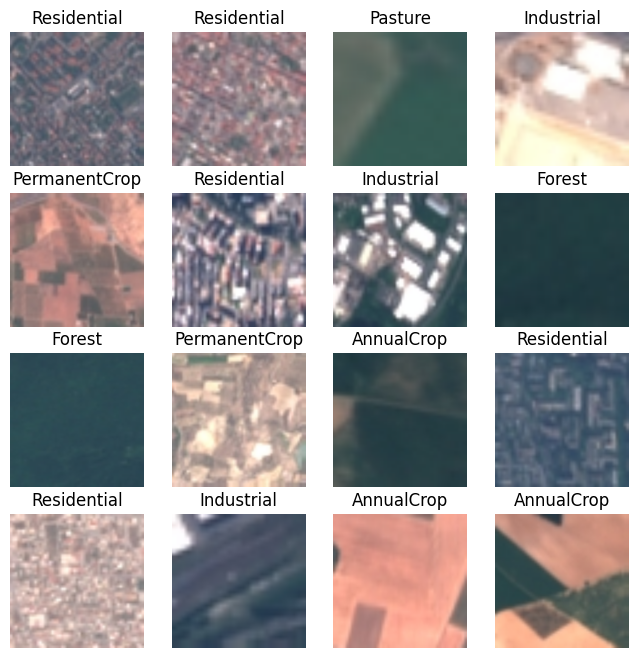

In [13]:
n = 4
inputs, classes = next(iter(traind))
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
   
    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

In [14]:
model = models.resnet50(weights='DEFAULT')
model.fc = torch.nn.Linear(model.fc.in_features, len(eurosat.classes))
model = model.to(device)
# torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s] 


In [19]:
n_epochs = 10
lr = 3e-4

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  running_loss = 0.0
  running_total_correct = 0.0
  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(inputs)
    # Compute the loss
    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()        
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [21]:
def evaluate(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels) 
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [22]:
# Keep track of the best loss and
# best model weights with the lowest loss
best_loss = np.inf
best_model = None

# Train and test over n_epochs
for epoch in range(n_epochs):
  print("Epoch {}".format(epoch+1))
  train(model, traind, criterion, optimizer)
  test_loss, _ = evaluate(model, testd, criterion)
  
  if test_loss < best_loss:
    best_loss = test_loss
    best_model= model.state_dict()

Epoch 1


100%|██████████| 675/675 [04:03<00:00,  2.77it/s]


Train Loss: 0.39; Accuracy: 87.54


100%|██████████| 169/169 [00:23<00:00,  7.10it/s]


Test Loss: 8.29; Accuracy: 8.30
Epoch 2


100%|██████████| 675/675 [04:10<00:00,  2.70it/s]


Train Loss: 0.24; Accuracy: 92.06


100%|██████████| 169/169 [00:23<00:00,  7.08it/s]


Test Loss: 7.78; Accuracy: 22.67
Epoch 3


100%|██████████| 675/675 [04:10<00:00,  2.70it/s]


Train Loss: 0.20; Accuracy: 93.50


100%|██████████| 169/169 [00:23<00:00,  7.11it/s]


Test Loss: 7.37; Accuracy: 35.41
Epoch 4


100%|██████████| 675/675 [04:10<00:00,  2.70it/s]


Train Loss: 0.19; Accuracy: 93.85


100%|██████████| 169/169 [00:23<00:00,  7.15it/s]


Test Loss: 7.80; Accuracy: 34.50
Epoch 5


100%|██████████| 675/675 [04:10<00:00,  2.70it/s]


Train Loss: 0.18; Accuracy: 93.73


100%|██████████| 169/169 [00:23<00:00,  7.20it/s]


Test Loss: 9.35; Accuracy: 33.46
Epoch 6


100%|██████████| 675/675 [04:10<00:00,  2.69it/s]


Train Loss: 0.17; Accuracy: 94.05


100%|██████████| 169/169 [00:23<00:00,  7.18it/s]


Test Loss: 9.66; Accuracy: 34.52
Epoch 7


100%|██████████| 675/675 [04:09<00:00,  2.70it/s]


Train Loss: 0.17; Accuracy: 94.57


100%|██████████| 169/169 [00:23<00:00,  7.13it/s]


Test Loss: 10.02; Accuracy: 27.80
Epoch 8


100%|██████████| 675/675 [04:09<00:00,  2.70it/s]


Train Loss: 0.16; Accuracy: 94.75


100%|██████████| 169/169 [00:23<00:00,  7.14it/s]


Test Loss: 11.29; Accuracy: 28.72
Epoch 9


100%|██████████| 675/675 [04:09<00:00,  2.70it/s]


Train Loss: 0.15; Accuracy: 95.10


100%|██████████| 169/169 [00:23<00:00,  7.21it/s]


Test Loss: 9.37; Accuracy: 40.17
Epoch 10


100%|██████████| 675/675 [04:10<00:00,  2.70it/s]


Train Loss: 0.15; Accuracy: 95.12


100%|██████████| 169/169 [00:23<00:00,  7.12it/s]

Test Loss: 10.74; Accuracy: 36.52


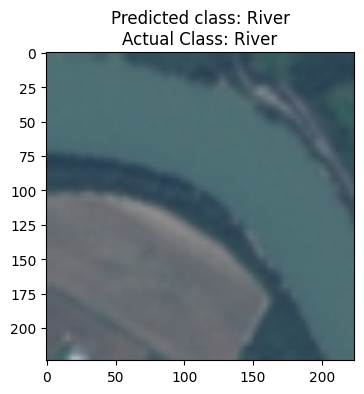

In [37]:
index = 1950
image, label = test_set[index]
image = image.to(device)
# label = label.to(device)

# Predict on sample
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(64, 64)


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpcrk5f63g.PNG'


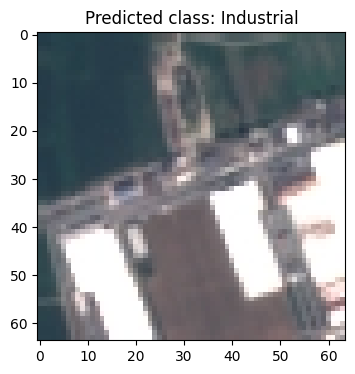

In [34]:
from PIL import Image 
import json 
import io 
img_path = "/kaggle/input/industries5/Industrial_5.jpg" 

# image = Image.open(img_path)
# image = Image.open(image)
image = Image.open(img_path)
# image = image.to(device)
# image.show()
# image

print(type(image)) 
print(image.size)
image.show()

# Transform image
input = test_transform(image)
input = input.to(device)
# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));